# Week 12: Chapter 11 - Capstone: Forecasting the number of antidiabetic drug prescriptions in Australia

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import itertools as itertls
import statsmodels.api as sm_api

from tqdm import notebook
from typing import Union

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error



In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

**Function declarations**

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y")
    # formatter = mdates.DateFormatter("%Y-%b")
    locator = mdates.YearLocator(base=2)
    # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)


The objective of the project in this week is forecasting the number of   
antidiabetic drug prescription in Australia, from 1991 to 2008.   
Predicting the number of antidiabetic drug prescription allows us to 
- produce enough numbers of drugs that meet the demand
- avoid overproduction.

## 11.1 Importing the required libraries and loading the data

We move all the imported libraries in the beginning of the notebook.


In [4]:
file_path = "./datasets/AusAntidiabeticDrug.csv"
df_drugs = pd.read_csv(file_path, parse_dates=[0])
df_drugs

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


## 11.2 Visualizing the series and its components

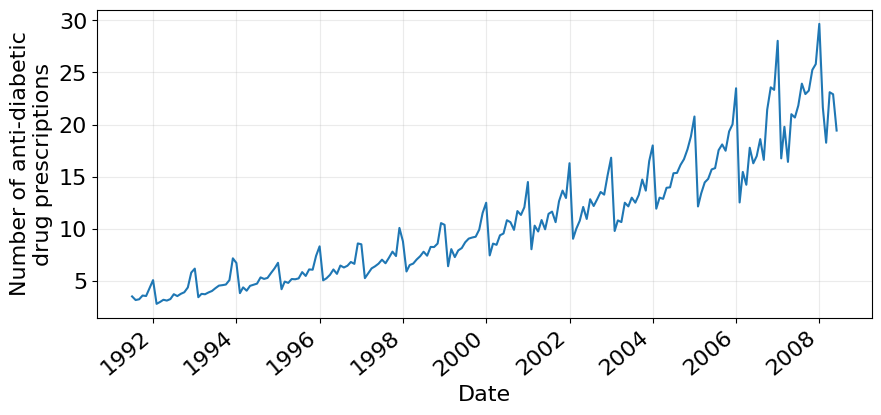

In [5]:
plot_time_series(df_drugs["ds"], df_drugs["y"], xlabel="Date", 
                  ylabel="Number of anti-diabetic\ndrug prescriptions")

In figure above, we see a clear trend in the time series, as the number of
prescriptions increases over time.   
Furthermore, we observe strong seasonality, as each year seems to start at a 
low value and end at a high value.

In this capstone project, we perform the following steps:
1. The objective is to forecast 12 months of antidiabetic drug prescriptions.  
   Use the last 36 months of the dataset as a test set to allow for rolling
   forecasts
2. Model the series with the usual steps:    
   a. Apply transformations to make it stationary.   
   b. Set the values of $d$ and $D$. Set the value of $m$.   
   c. Find the optimal $(p, d, q)(P, D, Q)_m$ parameters.   
   d. Perform residual analysis to validate your model.
3. Perform rolling forecasts of 12 months on the test set.
4. Visualize the forecasts.
5. Compare the model's performance to a baseline. Select an appropriate baseline  
   and error metric.
6. Conclude whether the model should be used or not.

In [6]:
drugs_decomposition = STL(df_drugs["y"], period=12).fit()
drugs_decomposition

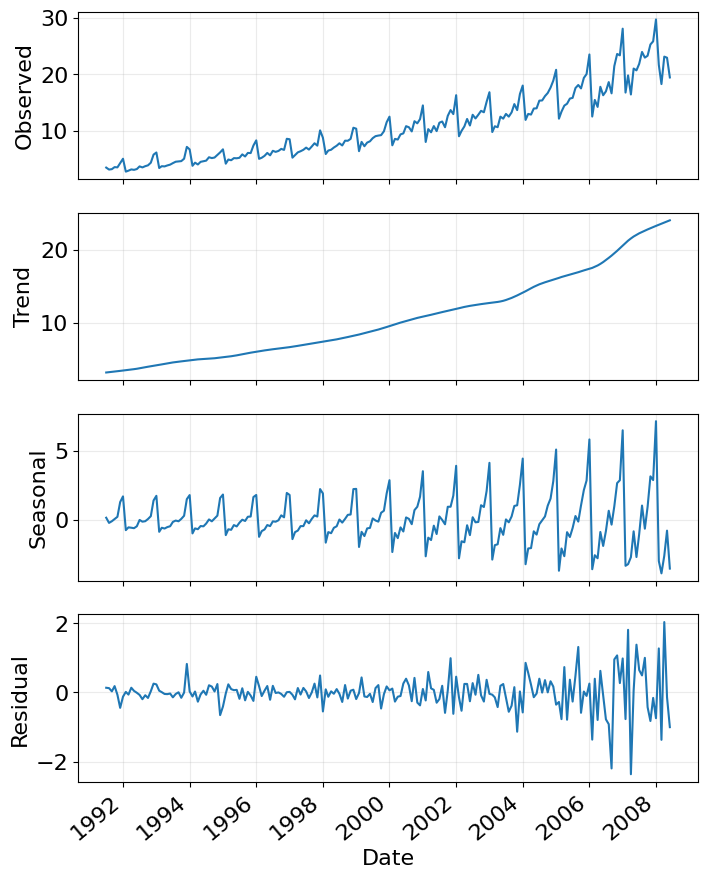

In [7]:
fig, axes = plt.subplots(nrows=4, figsize=(8, 10), sharex=True)

axes[0].plot(df_drugs["ds"], drugs_decomposition.observed)
axes[1].plot(df_drugs["ds"], drugs_decomposition.trend)
axes[2].plot(df_drugs["ds"], drugs_decomposition.seasonal)
axes[3].plot(df_drugs["ds"], drugs_decomposition.resid)

formatter = mdates.DateFormatter("%Y")
locator = mdates.YearLocator(base=2)
axes[3].xaxis.set_major_formatter(formatter)
axes[3].xaxis.set_major_locator(locator)
for label in axes[3].get_xticklabels():
  label.set_rotation(40)
  label.set_horizontalalignment("right")

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

From the plot above, it seems to suggest to use $\text{SARIMA}(p, d, q)(P, D, Q)_m$  
model because we have a trend and also a seasonality.  
We do not have any exogenous variables to work with, so the SARIMAX model cannot 
be applied. Finally, we wish to predict only one target, meaning
that a VAR model is also not relevant in this case.

## 11.3 Modeling the data

We have decided to use SARIMA model. The following general procedure for
finding the best SARIMA model is given below:

<img src="./figures/identify-nonstationary-general-procedure-sarima.drawio.png" width=600>

### Determine the seasonal integrated order $D$

In [8]:
ADF_result = adfuller((df_drugs["y"]))
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 3.145185689306745
p-value: 1.0


The $p$-value is larger than 0.05. This means that we cannot reject the null
hypothesis (the time series is not stationary). The next step is apply
transformation

In [9]:
drugs_first_diff = np.diff(df_drugs["y"], n=1)
ADF_result = adfuller(drugs_first_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")


ADF statistic: -2.4951721474497286
p-value: 0.1166534168646905


The $p$-value is still larger than 0.05. We hold this $d$ order and 
continue with seasonal first differencing to get the order $D$.

In [10]:
drugs_first_diff_seasonal = np.diff(drugs_first_diff, n=12)
ADF_result = adfuller(drugs_first_diff_seasonal)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -19.84844009708973
p-value: 0.0


Because we have a large and negative ADF statistic and a $p$-value that is  
smaller than $0.05$, we reject the null hypothesis and conclude that our  
transformed series is stationary. We have the combination of $(d, D) = (1, 1)$


### Define the range of possible values for $p$, $q$, $P$, and $Q$.

In [11]:
p_space = range(0, 5, 1)  
q_space = range(0, 5, 1)
P_space = range(0, 5, 1)   
Q_space = range(0, 5, 1)

d = 1
D = 1   # set D = 0, because we are working with ARIMA(p,d,q)
m = 12

sarima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(sarima_order_list)}")
sarima_order_list


num. of possible paramters setting: 625


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 0, 4),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 1, 4),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 2, 4),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 0, 3, 4),
 (0, 0, 4, 0),
 (0, 0, 4, 1),
 (0, 0, 4, 2),
 (0, 0, 4, 3),
 (0, 0, 4, 4),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 0, 4),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 1, 4),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 2, 4),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 1, 3, 4),
 (0, 1, 4, 0),
 (0, 1, 4, 1),
 (0, 1, 4, 2),
 (0, 1, 4, 3),
 (0, 1, 4, 4),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 0, 4),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 1, 4),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 2, 4),
 (0, 2, 3, 0),
 (0, 2, 3,

### Determine the best SARIMA model

Define the function to find the best SARIMA model

In [12]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    D: int, m: int,
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  # warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    # print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      seasonal_order=(order[2], D, order[3], m), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q,P,Q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df


Separate between train and test where the test is the last 36 months.

In [13]:
df_train = df_drugs[:-36]
df_test = df_drugs[-36:]

print(f"{len(df_train), len(df_test)}: {len(df_train), len(df_test)}")

(168, 36): (168, 36)


Iterate over all possible models $(p, q, P, Q)$

In [14]:
# # Computational time:  134 mins  58 secs
# sarima_result_df = optimize_SARIMA(df_train["y"], sarima_order_list, d,
#                           D, m, enforce_invertibility=True, enforce_stationarity=True)

In [15]:
# sarima_result_df.to_csv("./results/ch-11-sarima-drugs-result.csv", index=False)

In [16]:
reload_sarima_result_df = pd.read_csv("./results/ch-11-sarima-drugs-result.csv")
reload_sarima_result_df.head(100).values

array([['(3, 1, 1, 3)', 270.9510957588757],
       ['(2, 4, 1, 3)', 271.21711515642784],
       ['(3, 3, 1, 3)', 271.4224046277057],
       ['(4, 1, 1, 3)', 272.14529258252105],
       ['(0, 4, 1, 3)', 272.152379993512],
       ['(3, 2, 1, 3)', 272.22263578904546],
       ['(2, 4, 0, 1)', 272.5457129197948],
       ['(3, 3, 0, 1)', 272.5804129623178],
       ['(3, 1, 1, 4)', 272.9092350964069],
       ['(3, 3, 2, 0)', 272.9494382456893],
       ['(2, 4, 2, 0)', 272.9496503156364],
       ['(3, 4, 1, 3)', 273.2318253755901],
       ['(1, 1, 1, 3)', 273.28158520387115],
       ['(3, 1, 2, 3)', 273.29121647047504],
       ['(0, 1, 1, 3)', 273.36740573463214],
       ['(0, 3, 1, 3)', 273.4207636086573],
       ['(0, 2, 1, 3)', 273.7019928565171],
       ['(1, 4, 1, 3)', 273.80135723815414],
       ['(4, 4, 1, 3)', 273.8601904674558],
       ['(2, 4, 2, 3)', 274.0626643787582],
       ['(4, 1, 1, 4)', 274.09430314912487],
       ['(4, 2, 1, 3)', 274.12255481572765],
       ['(0, 4, 1, 4)', 

In [17]:
best_pqPQ = reload_sarima_result_df["(p,q,P,Q)"].iloc[0]
best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q \
  = tuple(map(int, best_pqPQ.strip("()").split(", ")))
print(f"best SARIMA (p,q,P,Q): {(best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q)}")

best SARIMA (p,q,P,Q): (3, 1, 1, 3)


Perform residual analysis

In [18]:
model_sarima_best = SARIMAX(df_train["y"], order=(best_sarima_p, d, best_sarima_q), 
                            seasonal_order=(best_sarima_P, D, best_sarima_Q, m),
                            simple_differencing=False)
model_sarima_best_fit = model_sarima_best.fit(disp=False)


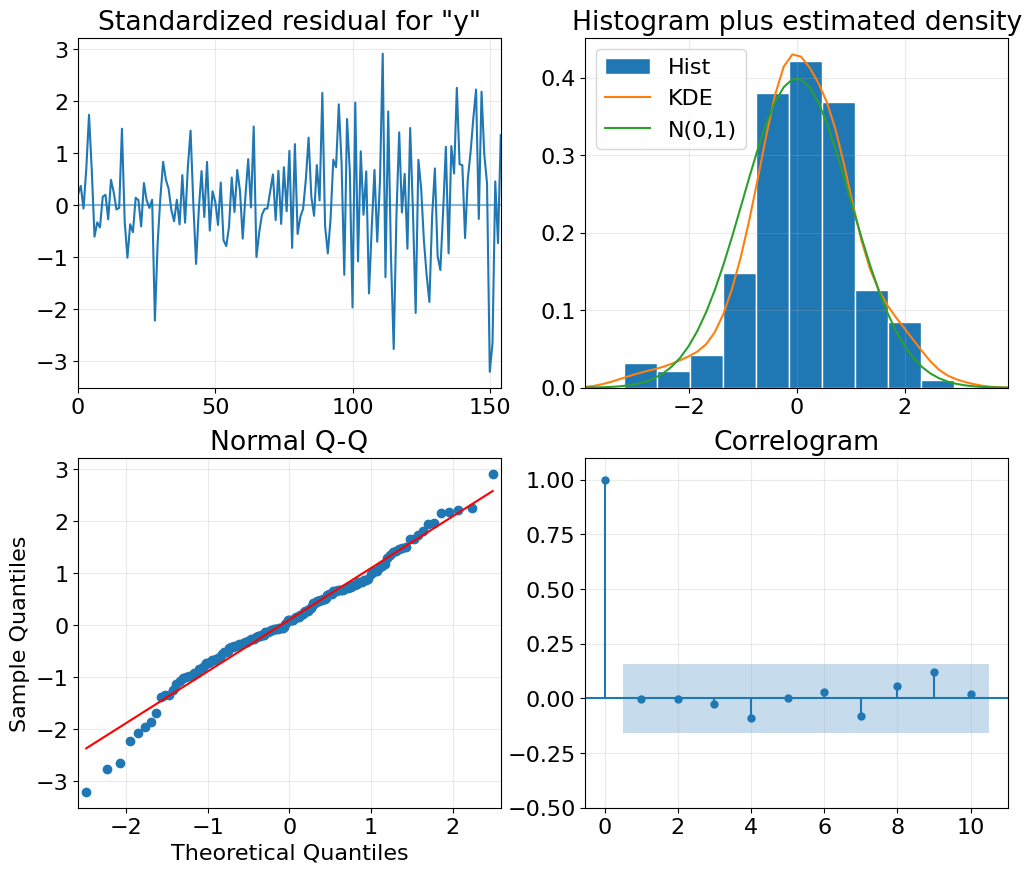

In [19]:
fig = model_sarima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)


Quantitative test for the residual analysis (Ljung-Box test)

In [20]:
residuals = model_sarima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.436938,0.508604
2,0.627667,0.730641
3,0.646160,0.885788
4,2.258462,0.688342
5,2.950628,0.707597
6,3.389581,0.758598
7,9.982156,0.189587
8,10.592106,0.225899
9,11.854186,0.221655
10,11.985493,0.286029


All the returned $p$-values are greater than 0.05. Therefore, we do not   
reject the null hypothesis, and we conclude that the residuals are independent  
and uncorrelated, just like the white noise.


Now we are ready to do forecasting for test data.


## 11.4 Forecasting and evaluating the model's performance

In [21]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str, 
                      df_column_name: str, 
                      sarima_order: tuple = None) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "last_season":
    pred_last_season = []

    for i in range(train_len, total_len, window):
      last_season = df[i-window:i][df_column_name].values
      pred_last_season.extend(last_season)

    return pred_last_season

  elif method == "SARIMA":
    pred_SARIMA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i][df_column_name],  
                      order=sarima_order[:3],
                      seasonal_order=sarima_order[3:], 
                      simple_differencing=False)
      res = model.fit(disp=False)
      
      predictions = res.get_prediction(0, i+window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarima
      pred_SARIMA.extend(oos_pred)

    return pred_SARIMA



In [22]:
df_test_pred = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 12
best_sarima_order = (best_sarima_p, d, best_sarima_q, 
                     best_sarima_P, D, best_sarima_Q, m)

df_test_pred["pred_naive_seasonal"] = rolling_forecast(
  df_drugs, TRAIN_LEN, HORIZON, WINDOW, "last_season", "y")
df_test_pred["pred_sarima"] = rolling_forecast(
  df_drugs, TRAIN_LEN, HORIZON, WINDOW, "SARIMA", "y", sarima_order=best_sarima_order)

In [23]:
df_test_pred.head()

,ds,y,pred_naive_seasonal,pred_sarima
168,2005-07-01,15.829550,15.339097,16.745835
169,2005-08-01,17.554701,15.370764,16.619326
170,2005-09-01,18.100864,16.142005,17.255304
171,2005-10-01,17.496668,16.685754,18.107522
172,2005-11-01,19.347265,17.636728,18.722192


### Comparing the performance of each forecasting method

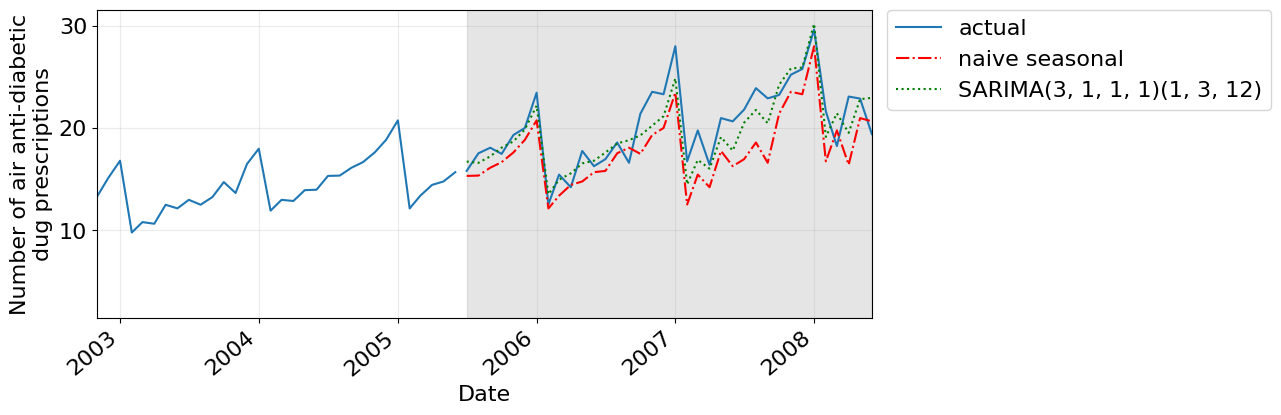

In [27]:
start_idx = 136  # for better visualization
xlim = [df_train["ds"].iloc[start_idx], df_test["ds"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["ds"], df_train["y"])
ax.plot(df_test["ds"], df_test["y"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y")
# formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=1)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Number of air anti-diabetic\ndug prescriptions")

# -- prediction
ax.plot(df_test_pred["ds"], df_test_pred["pred_naive_seasonal"], "r-.", 
        label="naive seasonal")
ax.plot(df_test_pred["ds"], df_test_pred["pred_sarima"], "g:", 
        label=f"SARIMA{best_sarima_order[:-3]}{best_sarima_order[-3:]}")

# add forecast area
ax.axvspan(df_test['ds'].iloc[0], df_test['ds'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

Evaluating the models

In [25]:
mape_naive_seasonal = mean_absolute_percentage_error(df_test_pred["y"], df_test_pred["pred_naive_seasonal"])*100
mape_sarima         = mean_absolute_percentage_error(df_test_pred["y"], df_test_pred["pred_sarima"])*100

print(f"MAPE naive seasonal: {mape_naive_seasonal:6.3f}%")
print(f"        MAPE SARIMA: {mape_sarima:6.3f}%")



MAPE naive seasonal: 12.687%
        MAPE SARIMA:  7.563%


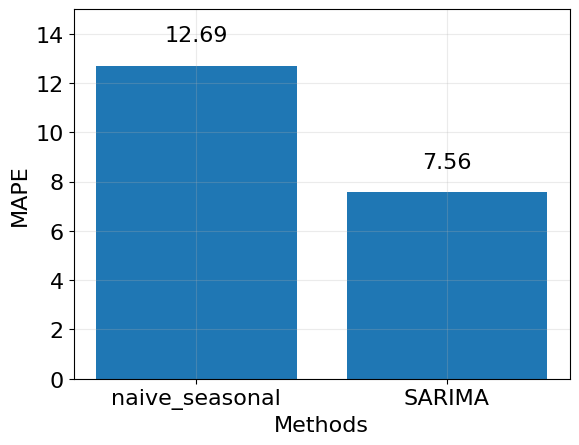

In [26]:
fig, ax = plt.subplots()

x_array = ["naive_seasonal", "SARIMA"]
y_array = [mape_naive_seasonal, mape_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+1., s=f"{val:.2f}", ha="center")

plt.show(fig)



Since the SARIMA model achieves the lowest MAPE, we can conclude that
the $\text{SARIMA}(3, 1, 3)(1, 1, 3)_{12}$ model should be used to forecast  
the monthly number of antidiabetic drug prescriptions in Australia.

## Next steps

In the next week, we will start a new section where we will use deep learning
models to model and forecast complex time series with high dimensionality.